## Project - *Recommender Systems Using KNN for Rate and Recommend Items by Amazon Reviews*
Author: Arman Hosseinsarraf



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

## 0. Function definitions

### Plot_Quantile() 
This function is a model of the Q-Q or quantile-quantile plot, which is a graphical tool to help us assess if a set of data plausibly came from some theoretical distribution such as a Normal or exponential. In other words, this kind of plots are used to find the type of distribution for a random variable whether it be a Gaussian Distribution, Uniform Distribution, Exponential Distribution or even Pareto Distribution. You can tell the type of distribution using the power of the Q-Q plot just by looking at the plot.

In [2]:
# Plot Quantiles
def plot_quantile(quantile):
    plt.figure(figsize=(8, 5))
    plt.title("Quantiles and their Values")
    quantile.plot()
    # quantiles with 0.05 difference
    plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
    # quantiles with 0.25 difference
    plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
    plt.ylabel('No of ratings by user')
    plt.xlabel('Value at the quantile')
    plt.legend(loc='best')
    plt.show()

### plot_rating_distribution()
Normal Distribution is an important concept in statistics and the backbone of Machine Learning. We need to know about Normal Distribution when we work with ML Models (models would perform better if the data is normally distributed), Central Limit Theorem, and exploratory data analysis. Hence, to have a better understanding of our data, we plot the distribution and number of reviews the data has for each score with this function

In [3]:
# Plot Data Distribution by Each Score
def plot_rating_distribution(data):
    
    plt.figure(figsize=(8,6))
    plt.rcParams['patch.force_edgecolor'] = True
    plt.title("Rating Distribution")
    plt.xlabel("Score")
    plt.ylabel("Number of Ratings")
    data['Rating'].hist(bins=100)

### plot_data_distribution()
As there are several ways of ploting and observing the dataset, I wanted to add another plot which shows the sum of the scores for each score in our dataset. 

In [4]:
def plot_data_distribution(data):
    plt.figure(figsize=(8,6))
    plt.rcParams['patch.force_edgecolor'] = True
    sns.jointplot(x='Rating', y='rating_counts', data=data, alpha=0.4)

## 1. Load Data

Load the dataset and observe the shapes and information of columns

In [5]:
# Load and Display the Data
electronics_data=pd.read_csv(r"ratings_Electronics.csv",names=['userId', 'productId','Rating','timestamp'])
electronics_data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [6]:
#Shape of the Data
electronics_data.shape

(7824482, 4)

In [7]:
#Check the datatypes
electronics_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   Rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


## 2. Using describe() function in pandas for column 'Rating'

In [8]:
#Five point summary 
electronics_data.describe()['Rating']

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [9]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_data.Rating.min()))
print('Maximum rating is: %d' %(electronics_data.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


In [10]:
#Check for missing values
print('Number of missing values across columns:\n',electronics_data.isnull().sum())

Number of missing values across columns:
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


## 3. Use sns bar graph to have a look at 'Rating' column before split and preprocessing

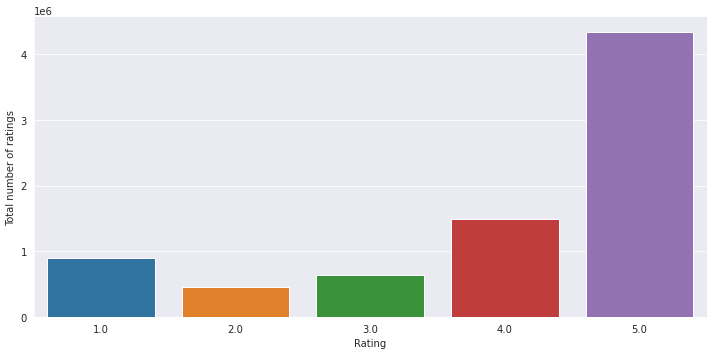

In [11]:
# Check the distribution of the rating before data preprocessing
with sns.axes_style('darkgrid'):
    plt_rate = sns.factorplot("Rating", data=electronics_data, aspect=2.0,kind='count')
    plt_rate.set_ylabels("Total number of ratings")

In [12]:
# Unique Users and products
print("Report of dataset")
print("-"*30)
print("Total Number of Ratings:\t",electronics_data.shape[0])
print("Total Number of Users:\t\t", len(np.unique(electronics_data.userId)))
print("Total Number of Products:\t", len(np.unique(electronics_data.productId)))

Report of dataset
------------------------------
Total Number of Ratings:	 7824482
Total Number of Users:		 4201696
Total Number of Products:	 476002


## 4. Cleaning the dataset with redundant columns for this project

Dataset includes lots of number of users that have bought different items ovetime. Recommender Systems work based on scores given by customers. Therefore, it is a good idea to see the number of reviews and scores each user has given.

In [13]:
#Dropping the Timestamp column
electronics_data.drop(['timestamp'], axis=1,inplace=True)

In [14]:
#Analysis of Rating Given by Each User 

no_of_rated_products_per_user = electronics_data.groupby(by='userId')['Rating'].count().sort_values(ascending=False)
no_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
Name: Rating, dtype: int64

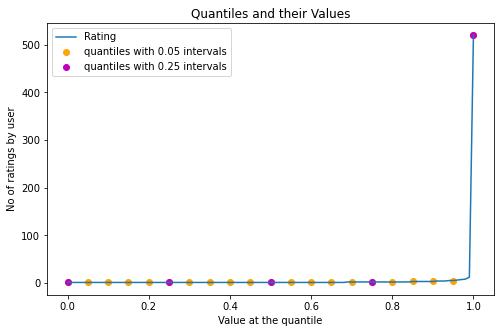

In [15]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')
plot_quantile(quantiles)

In [16]:
print('\n Number of Products rated by More Than 50 Users : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )


 Number of Products rated by More Than 50 Users : 1540



## 5. Creating a New Dataframe with Items Being Rated More than 50 Times.

In [18]:
#Getting the new dataframe which contains users who has given 50 or more ratings
new_df=electronics_data.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

Calculating the Mean of Ratings for Rach Item

In [19]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
ratings_mean_count.head()

,Rating,rating_counts
productId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


## 6. Plotting the Data Distribution for Each Score

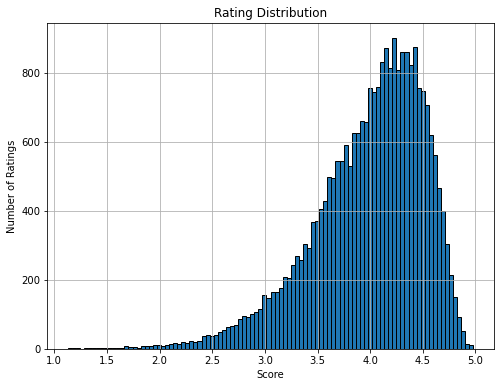

<Figure size 576x432 with 0 Axes>

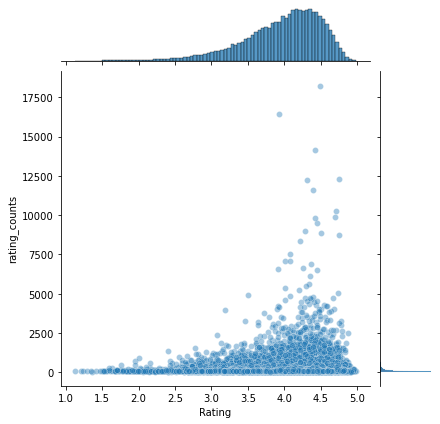

In [20]:
plot_rating_distribution(ratings_mean_count)
plot_data_distribution(ratings_mean_count)

## 7. Collaberative Filtering (Item-Based recommedation)
Collaborative filtering is commonly used for recommender systems. In the newer, narrower sense, collaborative filtering is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating) and we are going to use the collaborative filtering (CF) approach in this project. CF is based on the idea that the best recommendations come from people who have similar tastes. In other words, it uses historical item ratings of like-minded people to predict how someone would rate an item. Collaborative filtering has two sub-categories that are generally called memory-based and model-based approaches.

In [21]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

## 8. Creating train, test dataset

In [22]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df,reader)

In [23]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

## 9. Create an object from KNN model, train, and evaluate 

When we create the model, we use user_based true/false to switch between user-based or item-based collaborative filtering as it mentioned earlier, there is two type of recommendation (user-based, item-based).

In [29]:
model = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
model.fit(trainset)

# run the trained model against the testset
test_pred = model.test(testset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


## 10. Evaluate the model

Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit. To compute RMSE, calculate the residual (difference between prediction and truth) for each data point, compute the norm of residual for each data point, compute the mean of residuals and take the square root of that mean. RMSE is commonly used in supervised learning applications, as RMSE uses and needs true measurements at each predicted data point. In this project, we use 'surprise' library's accuracy to predict the models performance

In [121]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.3335


1.3334560899557941

Mean Absolute Error, or MAE, is a popular metric because, like RMSE, the units of the error score match the units of the target value that is being predicted. There is no correct value for MSE. Simply put, the lower the value the better and 0 means the model is perfect. Since there is no correct answer, the MSE's basic value is in selecting one prediction model over another

In [130]:
accuracy.mae(test_pred, verbose=True)

MAE:  1.0304


1.0303952036796318

The quality metric we use measures the proportion of well ranked items pairs, denoted by FCP (for Fraction of Concordant Pairs). FCP higher is better.

In [ ]:
accuracy.fcp(test_pred, verbose=True)

FCP:  0.5913


0.5913293964784024

## 11. Model-based collaborative filtering system
These methods are based on machine learning and data mining techniques. The goal is to train models to be able to make predictions. For example, we could use existing user-item interactions to train a model to predict the top-5 items that a user might like the most. One advantage of these methods is that they are able to recommend a larger number of items to a larger number of users, compared to other methods like memory based approach. They have large coverage, even when working with large sparse matrices.

In [122]:
new_df1=new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
userId,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [123]:
X = ratings_matrix.T
X.head()

userId,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,...,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
productId,,,,,,,,,,,,,,,,,,,,,
0972683275,0,0,5,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1400532620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 12. Create an object from TruncatedSVD, fit it with the data, and use it as recommender

TruncatedSVD transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with sparse matrices efficiently.

In [124]:
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(76, 10)

In [125]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(76, 76)

Choose an item from the list and calculate its correlation matrix which shows its neighbours and their distance

In [126]:
item = X.index[43]
product_names = list(X.index)
product_ID = product_names.index(item)

correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID

array([-0.0301491 ,  0.7966682 ,  0.74808608,  0.43887933,  0.11082058,
       -0.01795957, -0.02109775,  0.53268431,  0.96799048,  0.20491787,
        0.28342956,  0.73155086,  0.94377287,  0.53766523,  0.97300839,
        0.88933669,  0.80992147, -0.21663785, -0.71061578, -0.67988119,
       -0.82628216, -0.7073724 ,  0.7261498 ,  0.82887914,  0.10674955,
       -0.31732752,  0.00846495,  0.95784879, -0.01383047,  0.09302953,
       -0.70699213, -0.81515592, -0.64735112, -0.89554075,  0.94321624,
        0.93803443,  0.82619944,  0.31092818,  0.01509699,  0.90449822,
        0.56058093,  0.98071415,  0.5895107 ,  1.        ,  0.95766464,
       -0.50121148, -0.00318786, -0.884605  ,  0.46984103, -0.72121244,
        0.98591528,  0.6766589 ,  0.98430435,  0.96678286,  0.64387703,
       -0.43238449, -0.44433719,  0.09868562, -0.54042139,  0.74094967,
        0.96380497, -0.06543503,  0.15753932, -0.1711082 , -0.824448  ,
        0.50559452, -0.57754812,  0.72163635, -0.02213979, -0.79

Filter the values that are greater than 0.65 to be recommended to the user. The higher the correlation_product_ID, the stronger the recommendation

In [127]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(item) 

Recommend[0:5]

['1400501466', '1400501520', '1400599997', '6301977173', '7214047977']

In [110]:
no_of_rated_products_per_user.describe()

count    4.201696e+06
mean     1.862220e+00
std      2.885110e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      5.200000e+02
Name: Rating, dtype: float64

In [ ]:
#Getting the new dataframe which contains users who has given 50 or more ratings
new_df=electronics_data.groupby("productId").filter(lambda x:x['Rating'].count() >=50)